# LMUNet: Landscape metrics unet

**ORIGINAL SOURCE:** [Top 100 solution - SIIM-ACR Pneumothorax Segmentation](https://amaarora.github.io/2020/09/06/siimacr.html#train-and-valid-augmentations)

The Data-structure should look like this (old names: 

```
├── data
│   ├── dataset512
│   ├── dicom-images-test
│   └── dicom-images-train
└── src
    └── pneumothorax-segmentation 
```


## Preparations

### a)  Imports

remove obsolete ones

In [1]:
import os
import torch
import numpy as np
import pandas as pd
import cv2
from pathlib import Path
import matplotlib.pyplot as plt
#import segmentation_models_pytorch as smp
from torch.utils.data import DataLoader
import torch.nn as nn
#from torch.nn import MSELoss
from collections import defaultdict
import torchvision
import albumentations as albu
from albumentations.pytorch.transforms import ToTensorV2
import torch.nn.functional as F
from sklearn.model_selection import StratifiedKFold
#from torch.utils.data.sampler import Sampler
import sys; sys.path.append('../pneumothorax-segmentation/unet_pipeline/')
#from Losses import ComboLoss, dice_metric
#os.cpu_count()

In [2]:
#import tqdm
try:
    get_ipython().__class_._name__
    from tqdm.notebook import tqdm
except:
    from tqdm import tqdm

### b) Config (Hyperparameters)

The [ComboLoss](https://github.com/sneddy/pneumothorax-segmentation/blob/master/unet_pipeline/Losses.py#L104) function used in CRITERION below also comes from the winning solution by Anuar. 

```
Adjust:
    - file paths
    - batch size
    - learning rate
    - epochs
    - criterion (=loss function)
    - train or evaluate
    - etc
```

In [3]:
#DATA_DIR         = Path(f'../data/dataset{IMG_SIZE}/')
DATA_DIR         = Path(f'../notebooks/data')
#DATA_DIR         = Path(f'/data')
# TRAIN_IMG_DIR    = DATA_DIR/'100k_landscapes_no_classes' # 100k sidi 3 classes
#TRAIN_IMG_DIR_02    = DATA_DIR/'10k_sidi_5_class_ls' #10k 5 class
#TRAIN_IMG_DIR    = DATA_DIR/'10k_sidi_5_class_ls' # 10k 5 class
TRAIN_IMG_DIR    = DATA_DIR/'100k_landscapes_5_class' # 5 class 100k
#TRAIN_LBL_DIR    = DATA_DIR/'npy_10000_random_moving_window_sidi' # ???
#TRAIN_LBL_DIR    = DATA_DIR/'npy_3_class_lsm_l_sidi_5_mov_win' #100k sidi 3 class
#TRAIN_LBL_DIR    = DATA_DIR/'10k_contag_5_class_metr'  #10k 5 class
#TRAIN_LBL_DIR    = DATA_DIR/'100k_frac_mn_5_class_metr' # 100k 5 class
TRAIN_LBL_DIR    = DATA_DIR/'100k_joinent_5_class_metr'  #100k 5 class
#TRAIN_LBL_DIR_02    = DATA_DIR/'10k_frac_mn_5_class_metr' # 10k 5 class
#TRAIN_LBL_DIR    = DATA_DIR/'10k_sidi_5_class_metr'
#RLE_DF           = pd.read_csv('../data/train-rle.csv', names=['ImageId', 'EncodedPixels'], skiprows=1)
#RLE_DF           = pd.read_csv('data/metric_list_reti_futu.csv', names=['ImageId', 'EncodedPixels'], skiprows=1)
#RLE_DF           = pd.read_csv('data/100k_ls_metr.csv',  names=['ImageId', 'EncodedPixels'], skiprows=1)
#TRAIN_DF          = pd.read_csv('data/100k_ls_metr.csv', header=None) #100k sidi 3 class
TRAIN_DF          = pd.read_csv('data/100k_joinent_5_class_metric_list.csv', header=None) #100k 5 class
#TRAIN_DF_02           = pd.read_csv('data/metric_list_5_class_sidi_10k.csv', header=None)
#TRAIN_DF           = pd.read_csv('data/metric_list_5_class_sidi_10k.csv', header=None)
#KFOLD_PATH       = DATA_DIR/'RLE_kfold.csv'

In [4]:
IMG_SIZE         = 128
DATASET_LENGHTS = [80000,15000,5000] # example spolit for 100k
#TRAIN_BATCH_SIZE = 8
#VALID_BATCH_SIZE = 8
TEST_BATCH_SIZE = 8
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 16
USE_SAMPLER      = False
#POSTIVE_PERC     = 0.8
#ENCODER          = 'se_resnext50_32x4d'
#ENCODER_WEIGHTS  = 'imagenet'
#CLASSES          = ['mask']
#METRIC_NAMES     = ['lsm_l_sidi','lsm_l_joinent']
#NUM_METRICS      = len(['lsm_l_sidi','lsm_l_joinent'])
#ACTIVATION       = None 
DEVICE           = 'cuda'
LEARNING_RATE    = 2e-5
#LEARNING_RATE    = 0.1
#LEARNING_RATE    = 0.01
EPOCHS           = 50
#EPOCHS           = 100
#LOSS_FN          = 'mixed'
#LOSS_FN          = 'MSE'
#LOSS_FN          = 'RMSE'
LOSS_FN          = 'MAE'
#LOSS_FN          = 'R2'
#LOSS_FN           = 'pixels'
#EVAL_FN         = 'MSE'
EVAL_FN         = 'R2'
#CRITERION        = ComboLoss(**{'weights':{'bce':3, 'dice':1, 'focal':4}})
USE_CRIT         = True
KFOLD_SPLITS     = 10
#FOLD_IDS          = range(KFOLD_SPLITS-1)
FOLD_ID          = 8
TEST_ID           = 9
#NUM_WORKERS      = 4
NUM_WORKERS      = 12

In [5]:
#PRETRAINED_PATH  = '../data/bst_model512_fold2_0.9565.bin'
#PRETRAINED_PATH  = 'data/saved_models/first_working_evaluation_score/bst_model128_fold4_9.999999747378752e-05.bin'
#PRETRAINED_PATH  = 'outputs/saved_models/first_R2_sidi_3_5/bst_model128_fold4_0.9994000196456909.bin'
PRETRAINED_PATH  = 'outputs/saved_models/bst_model128_fold8_0.958899974822998.bin'
PRETRAINED       = False
TRAIN_MODEL      = True
TEST_MODEL       = False
#EVALUATE         = False
GRID_SEARCH      = False
GRID_SEARCH_OPTIM      = False


### c) Visualization functions

In [6]:
def matplotlib_imshow(img, one_channel=False):
    fig,ax = plt.subplots(figsize=(8,8))
    ax.imshow(img.permute(1,2,0).numpy())

In [7]:
def visualize(landscape, metric, left_title = "Landscape", right_title = "Metric"):
    """PLot images in one row."""
    #landscapes = {k:v.numpy() for k,v in landscapes.items() if isinstance(v, torch.Tensor)} #convert tensor to numpy 
    #landscape = landscape.numpy()
    #metric = metric.numpy()
    #n = len(landscapes)
    columns = 2
    rows = 1
    fig = plt.figure(figsize=(8, 8))
    fig.add_subplot(rows, columns, 1)
    plt.title(left_title)
    #plt.title("Landscape")
    #landscape, metric = landscapes['landscape'], landscapes['metric']
    #plt.imshow(landscape.transpose(1,2,0), vmin=0, vmax=1)
    plt.imshow(landscape)
    fig.add_subplot(rows, columns, 2)
    plt.title(right_title)
    #plt.title("Metric")
    plt.imshow(metric)
    #if metric.max()>0:
    #    plt.imshow(metric.squeeze(0), alpha=0.25)
    plt.show()

## Dataset

### d) Create k-fold splits - empty right now

In [8]:
'''
# create k folds train file if it doesn't exist already
if not os.path.exists(KFOLD_PATH):
    RLE_DF['has_mask'] = 0
    RLE_DF.loc[RLE_DF.EncodedPixels!='-1', 'has_mask'] = 1
    kf = StratifiedKFold(n_splits=KFOLD_SPLITS)
    RLE_DF['kfold']=-1
    for fold, (train_index, test_index) in enumerate(kf.split(X=RLE_DF.ImageId, y=RLE_DF.has_mask)):
            RLE_DF.loc[test_index, 'kfold'] = fold
    RLE_DF.to_csv(KFOLD_PATH, index=False)
'''

"\n# create k folds train file if it doesn't exist already\nif not os.path.exists(KFOLD_PATH):\n    RLE_DF['has_mask'] = 0\n    RLE_DF.loc[RLE_DF.EncodedPixels!='-1', 'has_mask'] = 1\n    kf = StratifiedKFold(n_splits=KFOLD_SPLITS)\n    RLE_DF['kfold']=-1\n    for fold, (train_index, test_index) in enumerate(kf.split(X=RLE_DF.ImageId, y=RLE_DF.has_mask)):\n            RLE_DF.loc[test_index, 'kfold'] = fold\n    RLE_DF.to_csv(KFOLD_PATH, index=False)\n"

In [9]:
'''
#for FOLD_ID in FOLD_IDS:
DF       = pd.read_csv(KFOLD_PATH)
TRAIN_DF = DF.query(f'kfold!={FOLD_ID} and kfold!={TEST_ID}').reset_index(drop=True)
VAL_DF   = DF.query(f'kfold=={FOLD_ID}').reset_index(drop=True)
TEST_DF  = DF.query(f'kfold=={TEST_ID}').reset_index(drop=True)
print(len(TRAIN_DF), len(VAL_DF), len(TEST_DF))
#print(TRAIN_DF.ImageId[0], VAL_DF.ImageId[0], TEST_DF.ImageId[0])
'''

"\n#for FOLD_ID in FOLD_IDS:\nDF       = pd.read_csv(KFOLD_PATH)\nTRAIN_DF = DF.query(f'kfold!={FOLD_ID} and kfold!={TEST_ID}').reset_index(drop=True)\nVAL_DF   = DF.query(f'kfold=={FOLD_ID}').reset_index(drop=True)\nTEST_DF  = DF.query(f'kfold=={TEST_ID}').reset_index(drop=True)\nprint(len(TRAIN_DF), len(VAL_DF), len(TEST_DF))\n#print(TRAIN_DF.ImageId[0], VAL_DF.ImageId[0], TEST_DF.ImageId[0])\n"

### e) Data augmentation ("transforms") - not working right now

In [10]:
'''
# Train transforms
TFMS = albu.Compose([
    ToTensorV2(),
    #albu.HorizontalFlip(always_app), # doesn't really matter?
    #albu.Rotate(limit=10),  # rotate could be fine, but needs to be the same
    #albu.Normalize(mean=[0.5], std=[0.5], max_pixel_value=1), # normalize also fine
    #ToTensorV2()
    ],
    #additional_targets={'metric': 'metric'}
)

# Test transforms
VAL_TFMS = albu.Compose([
    #albu.Normalize(),
    ToTensorV2(),
])
'''

"\n# Train transforms\nTFMS = albu.Compose([\n    ToTensorV2(),\n    #albu.HorizontalFlip(always_app), # doesn't really matter?\n    #albu.Rotate(limit=10),  # rotate could be fine, but needs to be the same\n    #albu.Normalize(mean=[0.5], std=[0.5], max_pixel_value=1), # normalize also fine\n    #ToTensorV2()\n    ],\n    #additional_targets={'metric': 'metric'}\n)\n\n# Test transforms\nVAL_TFMS = albu.Compose([\n    #albu.Normalize(),\n    ToTensorV2(),\n])\n"

In [11]:
'''
# chat gpt's suggestions:

import torch
import torchvision.transforms as transforms

# Define the transforms to be applied to the input images
# problem: not applied evenly on landscapes and metrics...
TFMS = transforms.Compose([
    transforms.ToTensor(),
    #transforms.RandomHorizontalFlip(),  # flips kind of pointless?
    #transforms.RandomVerticalFlip(),
    #transforms.functional.vflip(),    
    #transforms.RandomRotation(30),
    #transforms.functional.rotate(angle=30), # angle seems nice
    #transforms.RandomCrop(size=128),  # crop? yeah seems good.
    #transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1), #pointless
    #transforms.GaussianBlur(kernel_size=3), #pointless
    #transforms.Normalize(mean=[0.5], std=[0.5])
])

VAL_TFMS = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.5], std=[0.5])
])

TEST_TFMS = transforms.Compose([
    transforms.ToTensor()#,
    #transforms.Normalize(mean=[0.5], std=[0.5])
])


'''

"\n# chat gpt's suggestions:\n\nimport torch\nimport torchvision.transforms as transforms\n\n# Define the transforms to be applied to the input images\n# problem: not applied evenly on landscapes and metrics...\nTFMS = transforms.Compose([\n    transforms.ToTensor(),\n    #transforms.RandomHorizontalFlip(),  # flips kind of pointless?\n    #transforms.RandomVerticalFlip(),\n    #transforms.functional.vflip(),    \n    #transforms.RandomRotation(30),\n    #transforms.functional.rotate(angle=30), # angle seems nice\n    #transforms.RandomCrop(size=128),  # crop? yeah seems good.\n    #transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1), #pointless\n    #transforms.GaussianBlur(kernel_size=3), #pointless\n    #transforms.Normalize(mean=[0.5], std=[0.5])\n])\n\nVAL_TFMS = transforms.Compose([\n    transforms.ToTensor(),\n    #transforms.Normalize(mean=[0.5], std=[0.5])\n])\n\nTEST_TFMS = transforms.Compose([\n    transforms.ToTensor()#,\n    #transforms.Normalize(

### f) Dataset

In [12]:
# move to imports
from Dataset_test import LandscapeMetricsDataset
#from Dataset_test_kfold import LandscapeMetricsDataset

In [13]:
# normal working ones for using k-fold-validation
train_dataset = LandscapeMetricsDataset(TRAIN_DF, TRAIN_IMG_DIR, TRAIN_LBL_DIR)# , metr_norm=True)#, TFMS)# , TFMS)#, augmentation=transforms_train) 
#val_dataset   = LandscapeMetricsDataset(VAL_DF, TRAIN_IMG_DIR, TRAIN_LBL_DIR)#, VAL_TFMS)#, VAL_TFMS) 


In [14]:
#if loading multiple datasets from multiple folders with different indices:
# ie 3 classes + 5 classes
'''
train_dataset_01 = LandscapeMetricsDataset(TEST_DF, TRAIN_IMG_DIR, TRAIN_LBL_DIR)#, TFMS)# , TFMS)#, augmentation=transforms_train) 
train_dataset_02 = LandscapeMetricsDataset(TRAIN_DF_02, TRAIN_IMG_DIR_02, TRAIN_LBL_DIR_02)#, TFMS)# , TFMS)#, augmentation=transforms_train) 
len(train_dataset_02)
train_dataset_02[1]
'''

'\ntrain_dataset_01 = LandscapeMetricsDataset(TEST_DF, TRAIN_IMG_DIR, TRAIN_LBL_DIR)#, TFMS)# , TFMS)#, augmentation=transforms_train) \ntrain_dataset_02 = LandscapeMetricsDataset(TRAIN_DF_02, TRAIN_IMG_DIR_02, TRAIN_LBL_DIR_02)#, TFMS)# , TFMS)#, augmentation=transforms_train) \nlen(train_dataset_02)\ntrain_dataset_02[1]\n'

In [15]:
#concatenate both
#train_dataset = torch.utils.data.ConcatDataset([train_dataset_01, train_dataset_02])

In [16]:
len(train_dataset)

100000

In [17]:
# random_split conventinoally a 10k dataset
from torch.utils.data import random_split

train_dataset, val_dataset, test_dataset = random_split(dataset=train_dataset, 
                                                        #lengths=[80000,15000,5000], 
                                                        #lengths=[8000,1000,1000],
                                                        #lengths=[80000,10000,5954],
                                                        lengths=DATASET_LENGHTS,
                                                        generator=torch.Generator().manual_seed(42))

In [18]:
'''
train_dataset = LandscapeMetricsDataset(TRAIN_DF, TRAIN_IMG_DIR, TRAIN_LBL_DIR, TFMS) 
val_dataset   = LandscapeMetricsDataset(VAL_DF, TRAIN_IMG_DIR, TRAIN_LBL_DIR, TEST_TFMS) 

#landscapes_dataset = LandscapeMetricsDataset(ls_list=TRAIN_DF, landscape_dir=TRAIN_IMG_DIR, metrics_dir=TRAIN_LBL_DIR)
#landscapes_dataset = LandscapeMetricsDataset(ls_list=TRAIN_DF, landscape_dir=TRAIN_IMG_DIR, metrics_dir=TRAIN_LBL_DIR)
#landscapes_dataset = LandscapeMetricsDataset(ls_list=RLE_DF, landscape_dir=TRAIN_IMG_DIR, metrics_dir=TRAIN_LBL_DIR, augmentation=transforms_train)
#landscapes_dataset = LandscapeMetricsDataset(ls_list=RLE_DF, landscape_dir=TRAIN_IMG_DIR, metrics_dir=TRAIN_LBL_DIR, augmentation=TFMS)
'''

'\ntrain_dataset = LandscapeMetricsDataset(TRAIN_DF, TRAIN_IMG_DIR, TRAIN_LBL_DIR, TFMS) \nval_dataset   = LandscapeMetricsDataset(VAL_DF, TRAIN_IMG_DIR, TRAIN_LBL_DIR, TEST_TFMS) \n\n#landscapes_dataset = LandscapeMetricsDataset(ls_list=TRAIN_DF, landscape_dir=TRAIN_IMG_DIR, metrics_dir=TRAIN_LBL_DIR)\n#landscapes_dataset = LandscapeMetricsDataset(ls_list=TRAIN_DF, landscape_dir=TRAIN_IMG_DIR, metrics_dir=TRAIN_LBL_DIR)\n#landscapes_dataset = LandscapeMetricsDataset(ls_list=RLE_DF, landscape_dir=TRAIN_IMG_DIR, metrics_dir=TRAIN_LBL_DIR, augmentation=transforms_train)\n#landscapes_dataset = LandscapeMetricsDataset(ls_list=RLE_DF, landscape_dir=TRAIN_IMG_DIR, metrics_dir=TRAIN_LBL_DIR, augmentation=TFMS)\n'

In [19]:
len(train_dataset)

80000

In [20]:
# https://pytorch.org/docs/stable/data.html#torch.utils.data.random_split
# split dataset into training and testing. 
# rando generator seed for reproducabitly included!
#from torch.utils.data import DataLoader, random_split

# split dataset (size: 95954)
#train_dataset, val_dataset, test_dataset = random_split(dataset=landscapes_dataset, lengths=[1000,84000,10955], generator=torch.Generator().manual_seed(42))
#train_dataset, val_dataset, test_dataset = random_split(dataset=landscapes_dataset, lengths=[75000,10000,10954], generator=torch.Generator().manual_seed(42))
#train_dataset, val_dataset, test_dataset = random_split(dataset=landscapes_dataset, lengths=[750,125,125], generator=torch.Generator().manual_seed(42))


In [21]:
# sanity check
landscape, metric = train_dataset[136]['landscape'], train_dataset[136]['metric']
#landscape = train_dataset[1]['landscape']

landscape.shape, metric.shape
# (torch.Size([1, 128, 128]), torch.Size([1, 128, 128]))

(torch.Size([1, 128, 128]), torch.Size([1, 128, 128]))

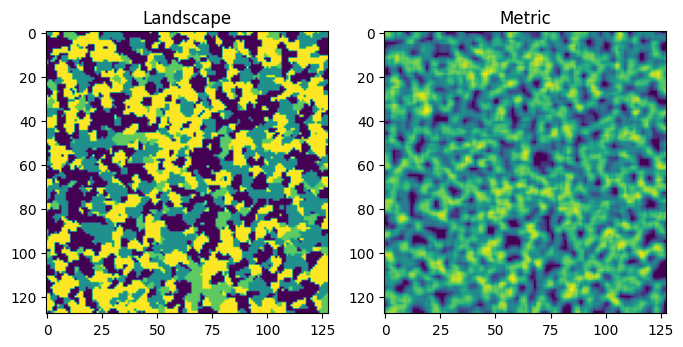

In [22]:
# plot one with mask 
visualize(train_dataset[0]['landscape'].squeeze(), train_dataset[0]['metric'].squeeze())


### g) Sampler

Do I want/need sampler? Using randomsampler, which is applied by setting shuffle=True in DataLoader

### h) DataLoaders

In [23]:
# dataloaders
# shuffle = True means random sampler, which is fine.
train_dataloader = DataLoader(train_dataset, TRAIN_BATCH_SIZE, 
                              shuffle=True if not USE_SAMPLER else False, 
                              num_workers=NUM_WORKERS, 
                              sampler=SAMPLER if USE_SAMPLER else None)
val_dataloader   = DataLoader(val_dataset, VALID_BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

In [24]:
# sanity check
landscapes, metrics = next(iter(train_dataloader))['landscape'], next(iter(train_dataloader))['metric']
landscapes.shape, metrics.shape
# should look like this: (torch.Size([14, 3, 512, 512]), torch.Size([14, 1, 512, 512]))

(torch.Size([16, 1, 128, 128]), torch.Size([16, 1, 128, 128]))

In [25]:
# plot train images
#ls_grid = torchvision.utils.make_grid(landscapes[:9], nrow=3, normalize=True)
#matplotlib_imshow(ls_grid)

In [26]:
#metr_grid = torchvision.utils.make_grid(metrics[:9], nrow=3, normalize=True)
#matplotlib_imshow(metr_grid)

## Model and Training

### i) Loss

In [27]:
# pixel wise mse loss
if LOSS_FN == 'pixels':
    def pixel_wise_mse_loss(input, target):
        return torch.mean((input - target)**2)
    criterion = pixel_wise_mse_loss

In [28]:
#losses
#LOSS_FN          = 'RMSE'

if LOSS_FN == 'MAE':
    criterion = nn.L1Loss()

# MSE
elif LOSS_FN == 'MSE' or LOSS_FN == 'RMSE':
    criterion = nn.MSELoss()

### j) Model

From [PyTorch Segmentation Models](https://github.com/qubvel/segmentation_models.pytorch):

In [29]:
#original
'''
import segmentation_models_pytorch as smp
#import segmentation_models_pytorch as smp

model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=3,     
    #classes=len(CLASSES), 
    activation=ACTIVATION,
)
'''

'\nimport segmentation_models_pytorch as smp\n#import segmentation_models_pytorch as smp\n\nmodel = smp.Unet(\n    encoder_name=ENCODER, \n    encoder_weights=ENCODER_WEIGHTS, \n    classes=3,     \n    #classes=len(CLASSES), \n    activation=ACTIVATION,\n)\n'

In [30]:
# importen just_unet
from unet_no_head import unet, Decoder

block_test torch.Size([1, 64, 128, 128])
encoder_test torch.Size([1, 64, 128, 128])
encoder_test torch.Size([1, 128, 64, 64])
encoder_test torch.Size([1, 256, 32, 32])
encoder_test torch.Size([1, 512, 16, 16])
decoder_test torch.Size([1, 64, 64, 64])
unet_output_dim_test torch.Size([1, 1, 128, 128])


In [31]:
#model = unet
#ENC_CHS = (1,64,128,256,512,1024)
#DEC_CHS= (1024,512,256,128,64)
ENC_CHS = (1,64,128,256,512)
DEC_CHS= (512,256,128,64)
model = unet(enc_chs=ENC_CHS, dec_chs=DEC_CHS)
#model = unet(enc_chs=ENC_CHS, dec_chs=DEC_CHS, num_metr=NUM_METRICS)
#model = unet(retain_dim=False)

### k) Early Stopping

epoch_score = accuracy at that epoch
model_path = where to save the model
patience = after how many steps of no progress to stop training

Saves one model when beginning, i.e. when no best score is yet available.
Why np.copy ? Maybe to turn epoch_score it into np object?

IF the accuracy (+delta) decreased: patience counter incremented by one, stopping once patience is reached.
Otherwise: continue trianing, reset counter, update best score with new score.

Save checkpoint: sved best score is intermittently saved as val_score, new best_score is compared to old val_score and printed out, state_dict is saved at model path.

In [32]:
class EarlyStopping:
    def __init__(self, patience=7, mode="max", delta=0.0001): # how big delta?
        self.patience = patience
        self.counter = 0
        self.mode = mode
        self.best_score = None
        self.early_stop = False
        self.delta = delta
        if self.mode == "min":
            self.val_score = np.Inf
        else:
            self.val_score = -np.Inf

    def __call__(self, epoch_score, model, model_path):
        if self.mode == "min":
            score = -1.0 * epoch_score
        else:
            score = np.copy(epoch_score)

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(epoch_score, model, model_path)

        elif ((EVAL_FN == 'MSE' and score > self.best_score - self.delta) or 
              (EVAL_FN == 'R2' and score < self.best_score + self.delta)):

            self.counter += 1
            print(
                "EarlyStopping counter: {} out of {}".format(
                    self.counter, self.patience
                )
            )
            if self.counter >= self.patience:
                self.early_stop = True
                #self.counter = 0
            
        else:
            self.best_score = score
            self.save_checkpoint(epoch_score, model, model_path)
            self.counter = 0

    def save_checkpoint(self, epoch_score, model, model_path):
        model_path = Path(model_path)
        parent = model_path.parent
        os.makedirs(parent, exist_ok=True)
        if epoch_score not in [-np.inf, np.inf, -np.nan, np.nan]:
            print(
                "Validation score improved ({} --> {}). Model saved at at {}!".format(
                    self.val_score, epoch_score, model_path
                )
            )
            torch.save(model.state_dict(), model_path)
        self.val_score = epoch_score

### l) Averagemeter

Averagemeter plays a role in taking care of the losses.

It's initialized in train_one_epoch, having the values set at zero.
Reset appears to be unused.
It gets updated with the current loss, which is handed as "val", and batch_size as n.
val is therefore the loss score.
sum is previous sum loss score plus val multiplied by batch size.
count is previous batches + new one
avg is sum of all loss scores divided by count of all batches.

Train one epoch is doing what it says it does.

In [33]:
class AverageMeter:
    def __init__(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

### m) Train one epoch

In [34]:
def train_one_epoch(train_loader, model, optimizer, loss_fn, accumulation_steps=1, device='cuda'):
    losses = AverageMeter()
    model = model.to(device)
    model.train()
    if accumulation_steps > 1: 
        optimizer.zero_grad()
    tk0 = tqdm(train_loader, total=len(train_loader))
    for b_idx, data in enumerate(tk0):
        for key, value in data.items():
            data[key] = value.to(device)
            #print(data['landscape'].size())
        if accumulation_steps == 1 and b_idx == 0:
            optimizer.zero_grad()
        out  = model(data['landscape'])
        #print(out.size())
        loss = loss_fn(out, data['metric'])
        if LOSS_FN == 'RMSE':
            loss = torch.sqrt(loss)
        with torch.set_grad_enabled(True):
            loss.backward()
            if (b_idx + 1) % accumulation_steps == 0:
                optimizer.step()
                optimizer.zero_grad()
        losses.update(loss.item(), train_loader.batch_size)
        tk0.set_postfix(loss=losses.avg, learning_rate=optimizer.param_groups[0]['lr'])
    return losses.avg

In [35]:
#print(train_one_epoch(train_loader=train_dataloader, model=model, optimizer=optimizer, loss_fn=criterion, accumulation_steps=1, device='cuda'))


### n) Evaluation Metric

In [36]:

# from ChatGPT adjusted:
# "When using Mean Squared Error (MSE) loss for image regression in PyTorch,
# you can compute the validation accuracy function using the following code:"
# useing torcheval.metrics.MeanSquaredError()
# torcheval.metrics.R2Score

#https://pytorch.org/torcheval/main/torcheval.metrics.html#regression-metrics
from torcheval.metrics import MeanSquaredError, R2Score

if EVAL_FN == 'MSE':
    eval_metric = MeanSquaredError()
    
elif EVAL_FN == 'R2':
    eval_metric = R2Score()

def evaluate(val_loader, model, device='cuda', criterion=eval_metric):
    """
    Computes the validation accuracy of the model on the validation set.
    """
    #losses = AverageMeter()
    #val_loss = 0.0
    
    model = model.to(device)
    model.eval() # set the model to evaluation mode
    tk0 = tqdm(val_loader, total=len(val_loader))

    with torch.no_grad():
        for b_idx, data in enumerate(tk0):
            for key, value in data.items():
                data[key] = value.to(device)
                #print(data['landscape'].size())
            out   = model(data['landscape'])  
                     
            # chatgpt suggest flaten:
            targets = data['metric']
            #inputs_flat = inputs.view(inputs.shape[0], -1)
            targets_flat = targets.view(targets.shape[0], -1).cpu()
            outputs_flat = out.view(out.shape[0], -1).cpu()
            # calculate the loss
            #loss = criterion(out, data['metric']).cpu()
            #criterion.update(out, data['metric']).cpu()
            criterion.update(outputs_flat, targets_flat)#.cpu()            
            val_loss = criterion.compute()

            #val_loss += loss.item() * landscapes.size(0) # accumulate the validation loss
            #losses.update(loss.mean().item(), val_loader.batch_size)
            #losses.update(loss.item(), val_loader.batch_size)
           
        # calculate the average validation loss
            #val_loss = val_loss / len(val_loader.dataset)
            
            tk0.set_postfix(val_score=val_loss)
            
        criterion.reset()
    
    # calculate the validation accuracy (in this case, MSE)
    #val_accuracy = val_loss
    #return losses.avg
    return val_loss
    #return val_accuracy


In [37]:
# testing evaluation function on pretrained model

#best_model_path = PRETRAINED_PATH
#model.load_state_dict(torch.load(best_model_path))
#model = model.to('cuda')
#print(evaluate(val_loader=val_dataloader, model=model, device='cuda', criterion=eval_metric))


In [38]:
# let's try this:
if PRETRAINED: 
    model.load_state_dict(torch.load(PRETRAINED_PATH))

In [39]:
optimizer = torch.optim.Adam(model.parameters(), lr= LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.MultiStepLR(
    optimizer, milestones=[3,5,6,7,8,9,10,11,13,15], gamma=0.75)

### o) Train model

In [40]:
#es = EarlyStopping(patience=3, mode='max')
es = EarlyStopping(patience=10, mode='max')

In [41]:
criterion

L1Loss()

In [42]:
if TRAIN_MODEL:
    for epoch in range(EPOCHS):
        loss = train_one_epoch(train_dataloader, model, optimizer, criterion)
        #dice = evaluate(val_dataloader, model, metric=acc_metric)
        #dice = evaluate(val_dataloader, model, metric=metric)
        #dice = evaluate(val_dataloader, model, criterion=criterion)        
        #dice = evaluate(val_dataloader, model, criterion=eval_metric)   
        eval_score = evaluate(val_dataloader, model, criterion=eval_metric)      
        scheduler.step()
        print(f"EPOCH: {epoch}, TRAIN LOSS: {loss}, VAL SCORE: {eval_score}")
        es(eval_score, model, model_path=f"../notebooks/outputs/saved_models/bst_model{IMG_SIZE}_fold{FOLD_ID}_{np.round(eval_score,4)}.bin")
        #best_model = f"../data/bst_model{IMG_SIZE}__fold{FOLD_ID}_{np.round(es.best_score,4)}.bin"
        #es(dice, model, model_path=f"../notebooks/data/bst_model{IMG_SIZE}_fold{FOLD_ID}_{str(np.round(dice,4))[2:]}.bin")
        #best_model = f"../notebooks/data/saved_models/bst_model{IMG_SIZE}__fold{FOLD_ID}_{np.round(es.best_score,4)}.bin"
        if es.early_stop:
            print('\n\n -------------- EARLY STOPPING -------------- \n\n')
            break
            
'''         ## whats this for?  
if EVALUATE: 
    #valid_score = evaluate(val_dataloader, model, metric=metric)
    valid_score = evaluate(val_dataloader, model, metric=acc_metric)
    print(f"Valid dice score: {valid_score}")
'''

100%|██████████| 938/938 [01:27<00:00, 10.78it/s, val_score=tensor(0.8333)]


EPOCH: 0, TRAIN LOSS: 0.43434955937862396, VAL SCORE: 0.8333263993263245
Validation score improved (-inf --> 0.8333263993263245). Model saved at at ../notebooks/outputs/saved_models/bst_model128_fold8_0.833299994468689.bin!


100%|██████████| 938/938 [01:27<00:00, 10.78it/s, val_score=tensor(0.8929)]


EPOCH: 1, TRAIN LOSS: 0.29465731594860556, VAL SCORE: 0.8928675651550293
Validation score improved (0.8333263993263245 --> 0.8928675651550293). Model saved at at ../notebooks/outputs/saved_models/bst_model128_fold8_0.8928999900817871.bin!


100%|██████████| 938/938 [01:27<00:00, 10.76it/s, val_score=tensor(0.9186)]


EPOCH: 2, TRAIN LOSS: 0.24252202736735343, VAL SCORE: 0.9185664057731628
Validation score improved (0.8928675651550293 --> 0.9185664057731628). Model saved at at ../notebooks/outputs/saved_models/bst_model128_fold8_0.9186000227928162.bin!


100%|██████████| 938/938 [01:27<00:00, 10.78it/s, val_score=tensor(0.9359)]


EPOCH: 3, TRAIN LOSS: 0.2117481371283531, VAL SCORE: 0.9358670115470886
Validation score improved (0.9185664057731628 --> 0.9358670115470886). Model saved at at ../notebooks/outputs/saved_models/bst_model128_fold8_0.9358999729156494.bin!


100%|██████████| 938/938 [01:26<00:00, 10.79it/s, val_score=tensor(0.9458)]


EPOCH: 4, TRAIN LOSS: 0.1920687064707279, VAL SCORE: 0.9457703828811646
Validation score improved (0.9358670115470886 --> 0.9457703828811646). Model saved at at ../notebooks/outputs/saved_models/bst_model128_fold8_0.9458000063896179.bin!


100%|██████████| 938/938 [01:26<00:00, 10.78it/s, val_score=tensor(0.9532)]


EPOCH: 5, TRAIN LOSS: 0.17652217378616333, VAL SCORE: 0.9531733989715576
Validation score improved (0.9457703828811646 --> 0.9531733989715576). Model saved at at ../notebooks/outputs/saved_models/bst_model128_fold8_0.9531999826431274.bin!


100%|██████████| 938/938 [01:27<00:00, 10.78it/s, val_score=tensor(0.9565)]


EPOCH: 6, TRAIN LOSS: 0.16558057712316512, VAL SCORE: 0.956488311290741
Validation score improved (0.9531733989715576 --> 0.956488311290741). Model saved at at ../notebooks/outputs/saved_models/bst_model128_fold8_0.9564999938011169.bin!


 32%|███▏      | 1601/5000 [04:58<10:34,  5.36it/s, learning_rate=6.33e-6, loss=0.16] 


KeyboardInterrupt: 

## Testing

### p) Predict Test Landscapes (single-model)

In [ ]:
'''
class TestDataset():
    def __init__(self, sample_sub, image_base_dir, augmentation=None):
        self.image_base_dir = image_base_dir
        self.image_ids      = sample_sub.ImageId.values
        self.augmentation   = augmentation
    
    def __getitem__(self, i):
        image_id  = self.image_ids[i]
        img_path  = os.path.join(self.image_base_dir, image_id+'.png') 
        image     = cv2.imread(img_path)
        image     = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)       
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image)
            image  = sample['image']

        return {
            'image': image, 
        }
        
    def __len__(self):
        return len(self.image_ids)
'''

In [ ]:
if TEST_MODEL or GRID_SEARCH or GRID_SEARCH_OPTIM:
    #test_dataset   = LandscapeMetricsDataset(TEST_DF, TRAIN_IMG_DIR, TRAIN_LBL_DIR)#, TEST_TFMS) 
    test_dataloader = DataLoader(test_dataset, TEST_BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

In [ ]:
if TEST_MODEL:
    #best_model_path = 'data/bst_model128_fold4_0185.bin'
    #best_model_path = 'data/bst_model128_fold4_0.0111.bin'
    #best_model_path = 'data/bst_model128_fold4_0.1103.bin'
    #best_model_path = 'data/bst_model128_fold4_0.1073.bin'
    #best_model_path = 'data/saved_models/bst_model128_fold4_0.0.bin'
    best_model_path = PRETRAINED_PATH

    model.load_state_dict(torch.load(best_model_path))
    #model.load_state_dict(torch.load('<path_to_bst_model>'))

In [ ]:
if TEST_MODEL:
    model = model.to('cuda')

In [ ]:
'''
if TEST_MODEL:
    def post_process(probability, threshold, min_size):
        mask = cv2.threshold(probability, threshold, 1, cv2.THRESH_BINARY)[1]
        num_component, component = cv2.connectedComponents(mask.astype(np.uint8))
        #predictions = np.zeros((1024, 1024), np.float32)
        predictions = np.zeros((128, 128), np.float32)    
        num = 0
        for c in range(1, num_component):
            p = (component == c)
            if p.sum() > min_size:
                predictions[p] = 1
                num += 1
        return predictions, num
'''

In [ ]:
if TEST_MODEL:
    def predict(test_dataloader, model, device='cuda'):
        predicted_pixels = []
        losses = AverageMeter()
        model = model.to(device)
        model.eval()
        tk0 = tqdm(test_dataloader, total=len(test_dataloader))
        for b_idx, data in enumerate(tk0):
            data['landscape'] = data['landscape'].to(device)
            out   = model(data['landscape'])
            out   = out.detach().cpu().numpy()[:, 0, :, :] 
            for out_ in out:
                 predicted_pixels.append(out_)
        return predicted_pixels
    

In [ ]:
if TEST_MODEL:
    predicted_metric = predict(test_dataloader,model)

In [ ]:
if TEST_MODEL:
    visualize(test_dataset[3]['landscape'].squeeze(), test_dataset[3]['metric'].squeeze())

In [ ]:
if TEST_MODEL:
    type(predicted_metric)
    len(predicted_metric)

In [ ]:
if TEST_MODEL:
    #visualize(predicted_metric[2],predicted_metric[2])
    visualize(test_dataset[3]['metric'].squeeze(),predicted_metric[3].squeeze(), left_title= "Metric", right_title = "Prediction")

In [ ]:
if TEST_MODEL:
    print(set(test_dataset[4]['metric'].squeeze()[1]))

In [ ]:
if TEST_MODEL:
    print(set(predicted_metric[4].squeeze()[1]))

In [ ]:
if TEST_MODEL:
    difference_loss = test_dataset[5]['metric']-predicted_metric[5]
    #difference_loss = abs(test_dataset[5]['metric']-predicted_metric[5])
    #(test_dataset[5]['metric']-predicted_metric[5]).squeeze()
    
    visualize(test_dataset[5]['metric'].squeeze(),difference_loss.squeeze(), left_title= "Metric", right_title = "Loss")
    #visualize(test_dataset[4]['metric'].squeeze(),predicted_metric[4].squeeze(), left_title= "Metric", right_title = "Prediction")

In [ ]:
if TEST_MODEL:
    print(np.count_nonzero(difference_loss))
    #128*128 == 16384
    print(set(difference_loss.squeeze()))

### q) Submit to Kaggle - `five fold`

In [ ]:
'''
def inference_image(model, images, device='cuda'):
    images = images.to(device)
    predicted = model(images)
    masks = torch.sigmoid(predicted)
    masks = masks.squeeze(1).cpu().detach().numpy()
    return masks
'''

In [ ]:
'''
def inference_model(model, loader, device, use_flip=False):
    mask_dict = {}
    for data in tqdm(loader):
        image_ids = data['image_id']
        images    = data['image']
        masks = inference_image(model, images, device)
        for name, mask in zip(image_ids, masks):
            mask_dict[name] = mask.astype(np.float32)
    return mask_dict
    '''

In [ ]:
'''
# Path to pretrained models from https://www.kaggle.com/aroraaman/siimacr-pretrained/
checkpoints_list=['../data/bst_model512_fold1_0.9492.bin', 
                  '../data/bst_model512_fold2_0.9565.bin', 
                  '../data/bst_model512_fold3_0.9608.bin', 
                  '../data/bst_model512_fold4_0.9604.bin']
'''

In [ ]:
'''
mask_dict = defaultdict(int)
for pred_idx, checkpoint_path in enumerate(checkpoints_list):
    model.load_state_dict(torch.load(checkpoint_path))
    model.eval()
    current_mask_dict = inference_model(model, test_dataloader, device='cuda')
    for name, mask in current_mask_dict.items():
        mask_dict[name] = (mask_dict[name] * pred_idx + mask) / (pred_idx + 1)
        
'''

In [ ]:
#len(mask_dict)

def creat_search_run():
    """
    Function to save the Grid Search results.
    """
    num_search_dirs = len(glob.glob('../outputs/search_*'))
    search_dirs = f"../outputs/search_{num_search_dirs+1}"
    os.makedirs(search_dirs)
    return search_dirs
def save_best_hyperparam(text, path):
    """
    Function to save best hyperparameters in a `.yml` file.
    :param text: The hyperparameters dictionary.
    :param path: Path to save the hyperparmeters.
    """
    with open(path, 'a') as f:
        f.write(f"{str(text)}\n")Model Paths for ensemble
- `../data/bst_model512_0.8193.bin` (fold-0)
- `../data/bst_model512_fold1_0.9492.bin` (fold-1)
- `../data/bst_model512_fold2_0.9565.bin`(fold-2)
- `../data/bst_model512_fold3_0.9608.bin` (fold-3)

### r) Gridsearch

In [ ]:
if GRID_SEARCH or GRID_SEARCH_OPTIM:
    '''
    import glob as glob
    def creat_search_run():
        """
        Function to save the Grid Search results.
        """
        num_search_dirs = len(glob.glob(' ../notebooks/data/grid_search/search_*'))       
        search_dirs = f" ../notebooks/data/grid_search/search_{num_search_dirs+1}"
        os.makedirs(search_dirs)
        return search_dirs
    '''
    def save_best_hyperparam(text, path):
        """
        Function to save best hyperparameters in a `.yml` file.
        :param text: The hyperparameters dictionary.
        :param path: Path to save the hyperparmeters.
        """
        #if os.stat(path).st_size == 0:
         #   with open(path, 'a') as f:          
          #      f.write(f"{str(text.keys())[11:-2]}\n")

        with open(path, 'a') as f:  
            if os.stat(path).st_size == 0:
                f.write(f"{str(text.keys())[11:-2]}\n")

            #f.write(f"{str(text)}\n")
            f.write(f"{str(text.values())[13:-2]}\n")

In [ ]:
if GRID_SEARCH:
    from sklearn.model_selection import ParameterGrid

    # define the grid search parameters
    param_grid = {
        #val batch size doesn't really matter?       
        'TRAIN_BATCH_SIZE': [8, 16],# 16],# 24]#, 32]#10, 20, 40, 60, 80, 100],  
        'LEARNING_RATE': [2e-4],# 2e-3, 0.01],#, 0.01]#,       
        'EPOCHS': [10],#, 50, 100],
        'LOSS_FN'   : ['MSE'] #['MAE', 'MAE']#, 'RMSE', 'MAE']
        #'EVAL_FN' : ['R2']#['MSE', 
        #'NUM_WORKERS'      = [4, 8, 12]
    }
    
#list(ParameterGrid(param_grid))


In [ ]:
2e-5 * 1000

In [ ]:
if GRID_SEARCH:  
    
    es = EarlyStopping(patience=3, mode='max')
    
    for param_dict in ParameterGrid(param_grid):
        TRAIN_BATCH_SIZE = param_dict['TRAIN_BATCH_SIZE']
        LEARNING_RATE = param_dict['LEARNING_RATE']
        EPOCHS = param_dict['EPOCHS']
        LOSS_FN = param_dict['LOSS_FN']
        #EVAL_FN = param_dict['EVAL_FN']

            # dataloaders # grid search with smaller learning size, i.e. 10k as in test data?
        train_dataloader = DataLoader(test_dataset, TRAIN_BATCH_SIZE, 
                                      shuffle=True if not USE_SAMPLER else False, 
                                      num_workers=NUM_WORKERS, 
                                      sampler=SAMPLER if USE_SAMPLER else None)

        optimizer = torch.optim.Adam(model.parameters(), lr= LEARNING_RATE)
        scheduler = torch.optim.lr_scheduler.MultiStepLR(
            optimizer, milestones=[3,5,6,7,8,9,10,11,13,15], gamma=0.75)

        if LOSS_FN == 'MAE':
            criterion = nn.L1Loss()

        # MSE & RMSE
        elif LOSS_FN == 'MSE' or LOSS_FN == 'RMSE':
            criterion = nn.MSELoss()
        
        es.counter = 0

        for epoch in range(EPOCHS):
            loss = train_one_epoch(train_dataloader, model, optimizer, criterion)
            eval_score = evaluate(val_dataloader, model, criterion=eval_metric)      
            scheduler.step()
            param_dict = {'EPOCH': epoch, 'TRAIN LOSS': loss, 'VAL SCORE': float(eval_score), 'LOSS FN': LOSS_FN, 'BATCH SZ': TRAIN_BATCH_SIZE }
            param_string = str(param_dict)
            print(param_string)
            es(eval_score, model, model_path=f"../notebooks/data/grid_search/bst_model{IMG_SIZE}_lr:_{LEARNING_RATE}_btch:_{TRAIN_BATCH_SIZE},lfn:_{LOSS_FN}_fold{FOLD_ID}_{np.round(eval_score,4)}.bin")
            #save_best_hyperparam(f"EPOCH: {epoch}, TRAIN LOSS: {loss}, VAL SCORE: {eval_score}, LOSS FN: {LOSS_FN}, BATCH SZ: {TRAIN_BATCH_SIZE}, LR: {LEARNING_RATE} ", f"../notebooks/data/grid_search/best_param.yml")
            #save_best_hyperparam(param_dict, f"../notebooks/data/grid_search/best_param.yml")
            save_best_hyperparam(param_dict, f"../notebooks/data/grid_search/best_param.csv")

            if es.early_stop:
                print('\n\n -------------- EARLY STOPPING -------------- \n\n')
                #es.counter = 0
                break

In [ ]:
if GRID_SEARCH_OPTIM:  
    
    from torch import optim
    es = EarlyStopping(patience=3, mode='max')

    # define the grid search parameters
    optim_grid = [optim.SGD, optim.RMSprop, optim.Adagrad, optim.Adadelta,
                      optim.Adam, optim.Adamax, optim.NAdam]
    
    
    for o in optim_grid:
        print(o)
        optimizer = o(model.parameters(), lr= LEARNING_RATE)

        # dataloaders # grid search with smaller learning size, i.e. 10k as in test data?
        train_dataloader = DataLoader(test_dataset, TRAIN_BATCH_SIZE, 
                                      shuffle=True if not USE_SAMPLER else False, 
                                      num_workers=NUM_WORKERS, 
                                      sampler=SAMPLER if USE_SAMPLER else None)

        #optimizer = torch.optim.Adam(model.parameters(), lr= LEARNING_RATE)
        scheduler = torch.optim.lr_scheduler.MultiStepLR(
            optimizer, milestones=[3,5,6,7,8,9,10,11,13,15], gamma=0.75)
        
        es = EarlyStopping(patience=3, mode='max')

        #es.counter = 0
          
        for epoch in range(EPOCHS):
            loss = train_one_epoch(train_dataloader, model, optimizer, criterion)
            eval_score = evaluate(val_dataloader, model, criterion=eval_metric)      
            scheduler.step()
            param_dict = {'OPTIMIZER': o, 'EPOCH': epoch, 'TRAIN LOSS': loss, 'VAL SCORE': float(eval_score), 'LOSS FN': LOSS_FN, 'BATCH SZ': TRAIN_BATCH_SIZE }
            param_string = str(param_dict)
            print(param_string)
            es(eval_score, model, model_path=f"../notebooks/data/grid_search_optim/bst_model{IMG_SIZE}_lr:_{LEARNING_RATE}_btch:_{TRAIN_BATCH_SIZE},lfn:_{LOSS_FN}_fold{FOLD_ID}_{np.round(eval_score,4)}.bin")
            save_best_hyperparam(param_dict, f"../notebooks/data/grid_search_optim/best_optim.csv")

            if es.early_stop:
                print('\n\n -------------- EARLY STOPPING -------------- \n\n')
                break